In [12]:
import os, random
import torch
import librosa
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

In [13]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

def _initialize_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

random_state = 42
_initialize_seed(random_state)

In [14]:
data_dir = "../input/ravdess/"
df_test = pd.read_csv(os.path.join(data_dir, "test.csv"))

In [15]:
def load_signals(df, sr=44100, **kwargs):
    singals = []
    for row in tqdm(df.itertuples(), desc="Processing...", total=len(df)):
        audio_signal,_ = librosa.core.load(os.path.join(data_dir, row.filepath), sr=sr, offset=kwargs.get("offset", 0.25), duration=kwargs.get("duration", 2.5))
        singals.append(audio_signal)
    return np.array(singals, dtype=np.float32)

In [16]:
def get_mfcc_features(signal, postfeatures="standardize", return_dims=1):
    assert(postfeatures in ["standardize","normalize"])
    assert(return_dims in [1,2])

    # Get MFCC
    x = librosa.feature.mfcc(y=signal)

    # Postprocess
    if postfeatures=="standardize":
        x = StandardScaler().fit_transform(x.T).T
    elif postfeatures=="normalize":
        x = 2.*(x - x.min(axis=1).reshape(-1,1))/(x.max(axis=1)-x.min(axis=1)).reshape(-1,1) - 1
    
    # Return
    return x.ravel() if return_dims==1 else x

In [17]:
X_test = load_signals(df_test)

Processing...: 100%|██████████| 120/120 [00:05<00:00, 21.85it/s]


## XGBoost

In [18]:
X_test_mfcc1D = np.array([get_mfcc_features(x, postfeatures="standardize", return_dims=1) for x in X_test])
y_test = df_test["emotion"].values
print(X_test_mfcc1D.shape, y_test.shape)

(120, 4320) (120,)


In [19]:
xgbc = joblib.load("../models/xgbc_v1_stdmfcc1D_2.5ms.joblib")
y_hat_test = xgbc.predict(X_test_mfcc1D)

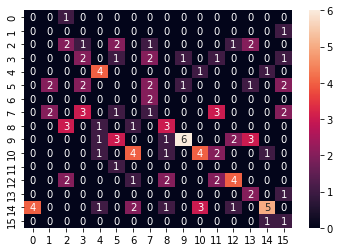

In [20]:
plt.figure(facecolor="white")
sns.heatmap(confusion_matrix(y_hat_test, y_test), annot=True)
plt.show()

In [21]:
accuracy_score(y_hat_test, y_test)

0.2833333333333333

## LSTM

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_classes = 16

class GetLSTMFeatures(torch.nn.Module):
    def __init__(self, mode, batch_first=True) -> None:
        super().__init__()
        self.mode = mode
        self.batch_first = batch_first
    def forward(self, x):
        output, (hn, cn) = x
        if self.mode=="full":
            return output
        return output[:,-1,:] if self.batch_first else output[-1,:,:]

lstm_model = torch.nn.Sequential(
    torch.nn.LSTM(input_size=20, hidden_size=64, num_layers=3, dropout=0.2, batch_first=True),
    # GetLSTMFeatures(mode="full"),
    # torch.nn.LSTM(input_size=16, hidden_size=8, num_layers=2),
    GetLSTMFeatures(mode="last"),
    torch.nn.Linear(in_features=64, out_features=32),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=32, out_features=n_classes)
).to(device)

In [23]:
lstm_model.load_state_dict(torch.load("../models/lstm_v3_stdmfcc2D_2.5ms.pt"))

<All keys matched successfully>

In [24]:
X_test_mfcc2D = np.array([get_mfcc_features(x, postfeatures="standardize", return_dims=2) for x in X_test])

In [25]:
X_test_mfcc2D.shape

(120, 20, 216)

In [26]:
y_pred_lstm = lstm_model(torch.tensor(X_test_mfcc2D.transpose((0,2,1))).to(device))
(torch.nn.functional.softmax(y_pred_lstm, dim=1).cpu().detach().numpy().argmax(axis=1)==y_test).sum()/len(y_test)

0.225

## CNN

In [27]:
X_melspec = []
for x in X_test:
    X_melspec.append(librosa.feature.melspectrogram(y=x, sr=44100, n_fft=1380, hop_length=345)/255.)
X_melspec = torch.tensor(X_melspec).to(device)

/tmp/ipykernel_193587/980442924.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  X_melspec = torch.tensor(X_melspec).to(device)


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_classes = 16

cnn_model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 32, 3, 2), # [?,1,128,320] -> [?,32,63,159]
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(),
    torch.nn.Conv2d(32, 64, 3, 2), # [?,32,63,159] -> [?,64,31,79]
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2), # [?,64,31,79] -> [?,64,15,39]
    torch.nn.Conv2d(64, 128, 3, 2), # [?,64,15,39] -> [?,128,7,19]
    torch.nn.BatchNorm2d(128),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2), # [?,128,7,19] -> [?,128,3,9]
    torch.nn.Flatten(),
    torch.nn.Linear(128*3*9, n_classes)
).to(device)

In [29]:
cnn_model.load_state_dict(torch.load("../models/cnn_v1_stdmfcc2D_2.5ms.pt"))

<All keys matched successfully>

In [30]:
y_pred_cnn = cnn_model(X_melspec.unsqueeze(axis=1))
(torch.nn.functional.softmax(y_pred_cnn, dim=1).cpu().detach().numpy().argmax(axis=1)==y_test).sum()/len(y_test)

0.2833333333333333

In [33]:
(torch.nn.functional.softmax(y_pred_lstm, dim=1).cpu().detach().numpy().argmax(axis=1)%2==y_test%2).sum()/len(y_test)

0.9083333333333333

In [39]:
(xgbc.predict(X_test_mfcc1D)%2 == y_test%2).sum() / len(y_test)

0.8583333333333333